<a href="https://colab.research.google.com/github/bbberylll/ESAA_OB/blob/main/ESAA_OB_M07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추천 시스템

## 추천시스템의 유형
1. 콘텐츠 기반 필터링
    - 사용자가 선호한 특정 아이템과 유사한 다른 아이템을 추천
    - 예시 : 특정 영화에 높은 점수 --> 해당 영화의 장르, 출연 배우, 키워드 등을 고려해 다른 컨텐츠 추천

2. 협업 필터링 방식 : 사용자가 매긴 평점 정보, 상품 구매 이력 등 **사용자 행동 양식**을 기반으로 추천 수행  
  - 사용자 - 아이템 평점 행렬 데이터에 의지해 추천을 수행함
      - 최근접 이웃 협업 필터링 = 메모리 협업 필터링
        > 사용자 기반 : 유저와 비슷한 고객 Top-N이 구매한 상품을 추천
                  - 고객 = row, 상품 = column

        > 아이템 기반 : 유저가 선택한 아이템을 똑같이 구매한 고객이 구매한 상품을 추천 --> 최근접 이웃 협업 필터링보다 성능이 더 좋음
                  - 고객 = column, 상품 = row

      - 잠재요인 협업 필터링
        > **행렬 분해 기법**을 이용한 필터링 방식.
        잠재요인을 기반으로
        **다차원 희소 행렬 사용자-아이템 행렬 데이터**
        = **저차원 밀집 행렬의 사용자-잠재요인 행렬 + 아이템-잠재요인 행렬의 전치행렬**로 분해 --> 두 행렬의 내적 --> 사용자가 예측하지 않은 아이템에 대한 평점을 도출 가능

        1. R : 사용자-아이템 평점 행렬.
              - R(u,i) = 사용자의 아이템에 대한 평점
        2. P = 영화 장르별 선호도 행렬 : 사용자-잠재 요인 행렬.
              - P(u,k) = 사용자의 특정 영화 장르에 대한 선호도
        3. Q = 영화의 장르별 요소 행렬 : 아이템-잠재 요인 행렬
              - Q(i,k)  --> Q.T(k,i) 로 변형

      평점 = 사용자의 특정 장르에 대한 선호도 * 개별 영화의 장르적 특성값
      R(1,1) = P(1,:) * Q.T(:,1)
      R(1,2) = P(1,:) * Q.T(:,2)


### 행렬 분해의 이해
1.  SVD, NMF 을 이용해서 다차원 행렬을 저차원 행렬 곱으로 분해
그러나 SVD는 NaN이 없는 행렬에만 적용 가능 --> **평점이 없는 값이 많을 경우 적용 불가능**

2. 확률적 경사 하강법 or ALS 방식으로 SVD 수행
  - P와 Q 행렬로 계산된 R 행렬 값이 실제 R 행렬과 최소의 오류를 갖도록
  **반복적으로 비용 함수 최적화 수행**

  1) P와 Q를 임의의 값을 가진 행렬로 설정
  2) P와 Q.T 값을 곱해 예측 R 행렬 계산 --> 실제 R 행렬과 비교해 오류 값 계산
  3) 오류값 최소화 과정 & P, Q 행렬 업데이트 진행 + 근사화까지 진행

  - 비용 함수 식 = min{(잔차 제곱 + 규제)의 합}
  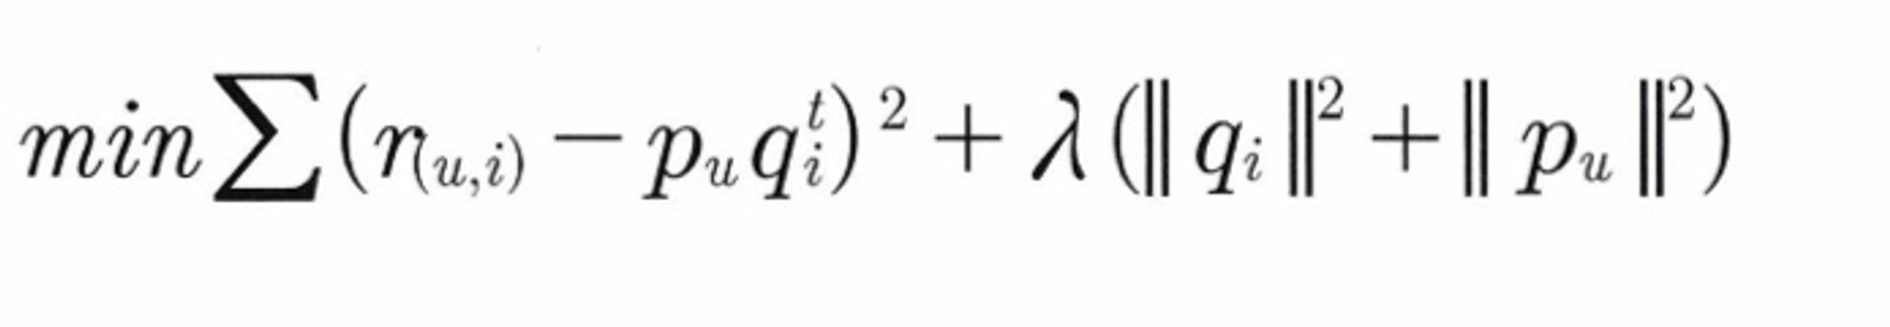



  pu :행렬의 사용자 u 행 벡터
  qt : 행렬의 아이템 i 행의 전치 벡터
  r(u,i) : 실제 r 행렬의 u, i 에 위치한 값
  hat_r : 예측 r 행렬의 u,i 값
  e = 잔차
  학습률, 규제 계수 정의

  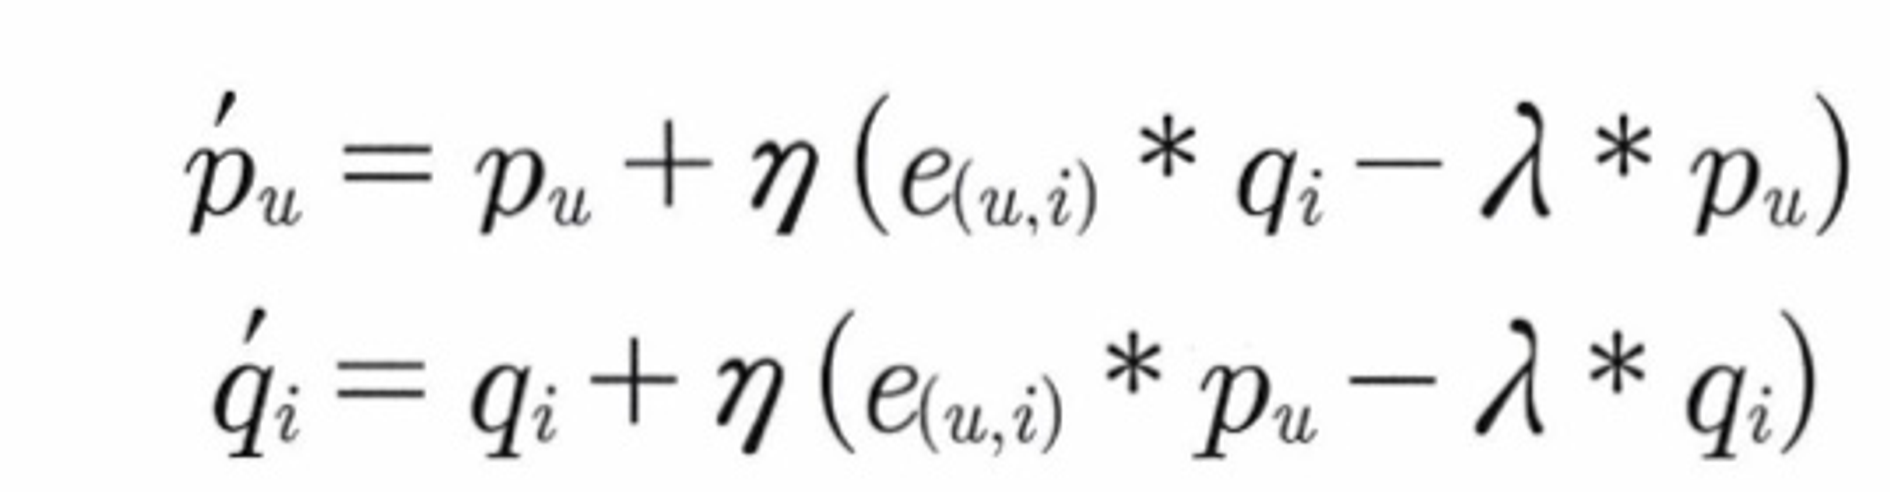

L2 규제를 반영해 실제 r 행렬과 예측 r 행렬의 차이를 최소화하는 방향성

In [2]:
import numpy as np

R = np.array([
    [4,np.nan, np.nan, 2, np.nan],
    [np.nan, 5, np.nan, 3,1],
    [np.nan, np.nan, 3, 4, 4],
    [5, 2, 1, 2, np.nan]
])

num_users, num_items = R.shape
K = 3

np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users,K))
Q = np.random.normal(scale=1./K, size=(num_items,K))

In [3]:
from sklearn.metrics import mean_squared_error

def get_rmse(R,P,Q,non_zeros):
  error=0
  full_pred_matrix = np.dot(P,Q.T)

  # R 행렬에서 NULL이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [4]:
non_zeros = [(i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

steps=100
learning_rate = 0.01
r_lambda = 0.01

for step in range(steps):
  for i, j, r in non_zeros:
    eij = r - np.dot(P[i,:], Q[j,:].T)
    P[i,:] = P[i,:]+learning_rate*(eij*Q[j,:] - r_lambda*P[i,:])
    Q[j,:] = Q[j,:]+learning_rate*(eij*P[i,:] - r_lambda*Q[j,:])

    rmse = get_rmse(R,P,Q,non_zeros)
    if(step%50) == 0:
      print("### iteration step : ", step,"rmse : ", rmse)


### iteration step :  0 rmse :  3.261355059488935
### iteration step :  0 rmse :  3.26040057174686
### iteration step :  0 rmse :  3.253984404542389
### iteration step :  0 rmse :  3.2521583839863624
### iteration step :  0 rmse :  3.252335303789125
### iteration step :  0 rmse :  3.251072196430487
### iteration step :  0 rmse :  3.2492449982564864
### iteration step :  0 rmse :  3.247416477570409
### iteration step :  0 rmse :  3.241926055455223
### iteration step :  0 rmse :  3.2400454107613084
### iteration step :  0 rmse :  3.240166740749792
### iteration step :  0 rmse :  3.2388050277987723
### iteration step :  50 rmse :  0.5003190892212748
### iteration step :  50 rmse :  0.5001616291326989
### iteration step :  50 rmse :  0.49899601202578087
### iteration step :  50 rmse :  0.4988483450145831
### iteration step :  50 rmse :  0.49895189256631756
### iteration step :  50 rmse :  0.49833236830090993
### iteration step :  50 rmse :  0.4984148489378701
### iteration step :  50 rmse 

In [5]:
pred_matrix = np.dot(P, Q.T)
print("예측 행렬 : \n", np.round(pred_matrix,3))

예측 행렬 : 
 [[ 3.91   0.591  1.53   2.251  2.007]
 [ 6.171  4.947  0.956  2.814  1.033]
 [ 5.991 -0.281  2.961  3.81   4.024]
 [ 4.779  2.096  1.104  2.295  1.269]]
